In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
#warnings.filterwarning('ignore')
%matplotlib inline
from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV


<font size="2">Para o propósito dessa atividade, irei pular a etapa de EDA. Nessa etapa irei observar as correlações com a target e possíveis correlações entre as variáveis.

In [4]:
df_treino = pd.read_csv('diabetes.csv')
df_treino.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [126]:
df_treino.describe()
#insulina e skinthickness parecer ter outliers

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


In [9]:
df_treino.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
corr = df_treino.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


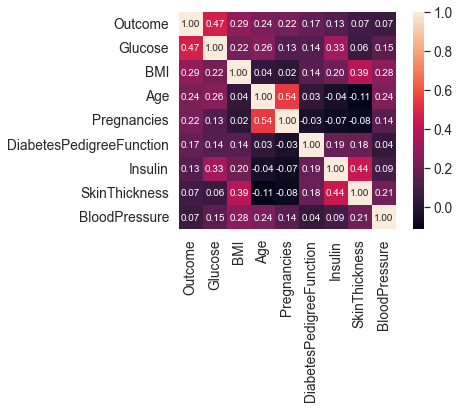

In [7]:
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'Outcome')['Outcome'].index
cm = np.corrcoef(df_treino[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<font size="2">Também para o propósito da atividade, ao invés de tratar os outliers das colunas Skinthickness e Insulin, irei simplesmente removê-las no treinamento.

In [8]:
corr['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64

In [35]:
#check balanceamento
df_treino['Outcome'].value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

<font size="2">Não temos variáveis relacionadas negativamente com nossa target, poderia ser um problema no caso de utilizarmos modelo de regressão, nesse caso irei utilizar todas (exceto as que possuem outliers)

In [127]:
y = df_treino['Outcome']
x = df_treino.drop(['Outcome','Insulin','SkinThickness'],axis=1)


In [128]:
from sklearn.model_selection import train_test_split

x_tr,x_test,y_tr,y_test = train_test_split(x,y,test_size = 0.3)

x_tr.shape, y_tr.shape, x_test.shape,y_test.shape

((537, 6), (537,), (231, 6), (231,))

<font size="2">Abaixo testes sem aprofundamento de modelos apenas para ter uma ideia do melhor ponto de partida. Vou ver como o modelo se sai com tudo em defeaut com Regressão Logistica, Random forest e um XGBOOST usando F1 SCORE score para avaliação

In [129]:
from sklearn.metrics import accuracy_score

#regressão logistica
from sklearn.linear_model import LogisticRegression
modelo2 = LogisticRegression()
modelo2.fit(x_tr,y_tr)
y_pred = modelo2.predict(x_test)
print(metrics.f1_score(y_test,y_pred))


0.6344827586206897


In [130]:
from sklearn.ensemble import RandomForestClassifier
modelo4 = RandomForestClassifier()
modelo4.fit(x_tr,y_tr)
y_pred = modelo4.predict(x_test)
print(metrics.f1_score(y_test,y_pred))

0.6410256410256411


In [131]:
clf = BalancedRandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_tr, y_tr)
y_pred = clf.predict(x_test)
print(metrics.f1_score(y_test,y_pred))

0.6741573033707865


In [132]:
from sklearn import metrics
model = XGBClassifier()
model.fit(x_tr, y_tr)
predictions = model.predict(x_test)
print(metrics.f1_score(y_test,predictions))

0.6335403726708074


<font size="2">Vou seguir com o balanced random forest - Rodar um gridsearch simples para tentar melhorar as métricas

In [133]:
rfc=BalancedRandomForestClassifier()

param_grid = { 
    'n_estimators': [100,300],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [134]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring='f1')
CV_rfc.fit(x_tr, y_tr)

GridSearchCV(cv=5, estimator=BalancedRandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 300]},
             scoring='f1')

In [135]:
print(CV_rfc.best_params_)
print(CV_rfc.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}
0.7039041295271972


<font size="2"> Uma melhora pouco significativa mas ainda assim uma melhora :P, podemos explorar outros parâmetros.

In [136]:
clf = BalancedRandomForestClassifier(max_depth=2,criterion='entropy',n_estimators=100)
clf.fit(x_tr, y_tr)
predictions = clf.predict_proba(x_test)[:,1]

<font size="2">Vou ver se esse score é estável e também checar a área abaixo da curva ROC

In [137]:
from sklearn.model_selection import cross_val_score,RepeatedKFold
from sklearn.metrics import roc_auc_score,f1_score,precision_score

kf = RepeatedKFold(n_splits=2,n_repeats=10, random_state=10)
resultados_cv = cross_val_score(clf,x_tr,y_tr,cv=kf,scoring='f1')
print(resultados_cv)
print(np.mean(resultados_cv))

[0.64840183 0.64347826 0.72380952 0.63478261 0.62068966 0.63559322
 0.67281106 0.67924528 0.66063348 0.70642202 0.68224299 0.68181818
 0.66666667 0.71028037 0.72222222 0.67676768 0.69955157 0.68867925
 0.67326733 0.67241379]
0.6749888493697487


In [138]:
from sklearn.model_selection import cross_val_score,RepeatedKFold
from sklearn.metrics import roc_auc_score,f1_score,precision_score

kf = RepeatedKFold(n_splits=2,n_repeats=10, random_state=10)
resultados_cv = cross_val_score(clf,x_tr,y_tr,cv=kf,scoring='roc_auc')
print(resultados_cv)
print(np.mean(resultados_cv))

[0.82590407 0.78610119 0.84857988 0.79911616 0.81981763 0.81474688
 0.84451369 0.82324308 0.84457497 0.8122962  0.83846799 0.84230459
 0.81477503 0.85168539 0.82365396 0.8425192  0.81674556 0.85631313
 0.84537205 0.82144393]
0.8286087294959573


<font size="2"> Para avaliar também a separação das classes, irei utilizar a estatística KS cuja função é comparar as distribuições acumulativas e verificar a diferenças entre eles. Nos mostra o quão bem o modelo discrimina evento do não evento.

In [139]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score
def evaluate_ks_and_roc_auc(y_real, y_proba):
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba
    
    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'] , df['proba'])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    return ks.statistic, roc_auc
print("Good classifier:")
ks_good, auc_good = evaluate_ks_and_roc_auc(y_test, predictions)

Good classifier:
KS: 0.5072 (p-value: 7.894e-13)
ROC AUC: 0.8083


In [140]:

def cdf(sample, x, sort = False):
    '''
    Return the value of the Cumulative Distribution Function, evaluated for a given sample and a value x.
    
    Args:
        sample: The list or array of observations.
        x: The value for which the numerical cdf is evaluated.
    
    Returns:
        cdf = CDF_{sample}(x)
    '''
    
    # Sorts the sample, if needed
    if sort:
        sample.sort()
    
    # Counts how many observations are below x
    cdf = sum(sample <= x)
    
    # Divides by the total number of observations
    cdf = cdf / len(sample)
    
    return cdf

In [141]:
def get_classes_cdf(y_real, y_proba):
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba
    
    # Recover each class
    class0 = df[df['real'] == 0].sort_values('proba')
    class1 = df[df['real'] == 1].sort_values('proba')
    
    # Calculates the cdfs
    cdf0 = np.array([cdf(class0['proba'].values, x, sort = False) for x in class0['proba'].values])
    cdf1 = np.array([cdf(class1['proba'].values, x, sort = False) for x in class1['proba'].values])
    
    # Results
    results =  {
        'cdf0': cdf0,
        'cdf1': cdf1,
        'proba0': class0['proba'].values, 
        'proba1': class1['proba'].values, 
    }
    
    return results

In [142]:
cdf_good = get_classes_cdf(y_test, predictions)

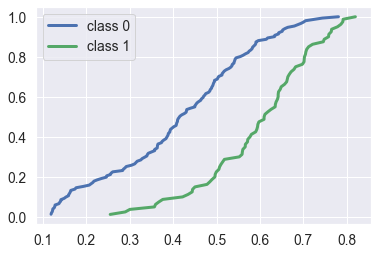

In [143]:
sns.lineplot(x = cdf_good['proba0'], y = cdf_good['cdf0'], color = 'b', linewidth = 3)
sns.lineplot(x = cdf_good['proba1'], y = cdf_good['cdf1'], color = 'g', linewidth = 3)
plt.legend(["class 0", "class 1"])

<font size="2">Com esse KS de 55% e o valor P < 5% podemos rejeitar a hipotese nula e concluir que a distribuição dos eventos versus não eventos são estatisticamente diferentes.

<font size="2">Pensando numa possível disponibilização para clientes, faz sentido fornecermos scores de propensão a diebetes para que o cliente final possa utilizar ao invés de probabilidades ou output de 0 ou 1 com threshold em 0,5%.

A ideia de usar os scores é separar as probabilidades em decis onde tenhamos mais ou menos a mesma quantidade de previsões no mesmo score.

In [119]:
N_BINS = 10
LABELS = [1,2,3,4,5,6,7,8,9,10]

#inclui as previsoes no dataframe de teste (e futuramente os novos dados que surgirem)
x_test['previsoes'] = predictions
x_test['y_real'] = y_test
df = x_test
df['bin_quantile'],bins_quantile = pd.qcut(df['previsoes'],q=10,retbins=True,labels=LABELS)


In [120]:
#ajusta o inicio e o fin dos labels
bins_quantile[0] = -0.1
bins_quantile[len(bins_quantile) -1] = 1.1

bins_quantile

array([-0.1       ,  0.23046288,  0.31779885,  0.38698063,  0.44170474,
        0.48405247,  0.51831502,  0.57611574,  0.64460026,  0.69173381,
        1.1       ])

<font size="2">Esses mesmos labels precisam ser aplicados em novos dados

In [121]:
with pd.option_context('display.float_format', '{:,.1%}'.format):
    agg_df = df.groupby('bin_quantile')['y_real'].agg(['mean','count'])
    agg_df["%"] = agg_df['count']/agg_df['count'].sum()
    agg_df.columns = ['%target','qtde','% total']
    display(agg_df)

,%target,qtde,% total
bin_quantile,,,
1,0.0%,24,10.4%
2,4.3%,23,10.0%
3,13.0%,23,10.0%
4,17.4%,23,10.0%
5,30.4%,23,10.0%
6,26.1%,23,10.0%
7,69.6%,23,10.0%
8,34.8%,23,10.0%
9,87.0%,23,10.0%


<font size="2">A ideia é quanto maior os labels/scores, mais da target deve ser capturada, não conseguimos ver esse movimento aqui talvez por ter poucos dados. Esperariamos um número crescente de captura da target. Por esse quadro temos apenas uma confiança maior utilizando os scores 9 e 10 de propensão a ter diabetes.

In [125]:
df.rename(columns={'bin_quantile':'propensao_diabetes'})

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,previsoes,propensao_diabetes,y_real
550,1,116,70,28,0,27.40,0.20,21,0.31,2,0
388,5,144,82,26,285,32.00,0.45,58,0.68,9,1
155,7,152,88,44,0,50.00,0.34,36,0.68,9,1
499,6,154,74,32,193,29.30,0.84,39,0.68,9,0
116,5,124,74,0,0,34.00,0.22,38,0.59,8,1
...,...,...,...,...,...,...,...,...,...,...,...
188,8,109,76,39,114,27.90,0.64,31,0.49,6,1
135,2,125,60,20,140,33.80,0.09,31,0.58,8,0
308,0,128,68,19,180,30.50,1.39,25,0.56,7,1
637,2,94,76,18,66,31.60,0.65,23,0.33,3,0


<font size="2">A disponibilização final seria a base com a coluna 'Propensao diebetes' onde teoricamente quanto maior o valor, mais propenso o paciente é a ter diebetes.

Conclusão:
<font size="2">Modelo mediano, com várias possibilidades de melhorias, principalmente dando mais atenção as features, removendo outliers e etc.